In [1]:
# Code and ideas from:
# https://hami-asmai.medium.com/relationship-extraction-from-any-web-articles-using-spacy-and-jupyter-notebook-in-6-steps-4444ee68763f

In [2]:
# !pip install https://github.com/explosion/spacy-experimental/releases/download/v0.6.1/en_coreference_web_trf-3.4.0a2-py3-none-any.whl

In [3]:
import re
import csv
import json
import math

import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span, Doc

from spacy.pipeline import merge_entities, merge_noun_chunks
from spacy.symbols import ORTH, POS, NOUN, VERB

import urllib.request 
from bs4 import BeautifulSoup

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

# !pip install coreferee
# !python3 -m coreferee install en

# !python3 -m spacy download en_core_web_lg

import coreferee

# Merged pipeline
nlp_coref = spacy.load('en_core_web_lg')
nlp_coref.add_pipe('coreferee')
nlp_coref.add_pipe('sentencizer')


patterns = [[{"LOWER": "hackerfriendly"}]]
attrs = {"TAG": "NNP", "POS": "PROPN", "DEP": "nsubj"}

ruler = nlp_coref.get_pipe("attribute_ruler")
ruler.add(patterns=patterns, attrs=attrs)

nlp_merged = spacy.load('en_core_web_lg')
nlp_merged.add_pipe('merge_entities')
nlp_merged.add_pipe('merge_noun_chunks')

ruler = nlp_merged.get_pipe("attribute_ruler")
ruler.add(patterns=patterns, attrs=attrs)


nlp = nlp_coref

In [4]:
spacy.explain('nsubj')

'nominal subject'

In [5]:
def referee(doc):
    if not isinstance(doc, spacy.tokens.doc.Doc):
        doc = nlp_coref(doc)
        
    sent = []
    for i, tok in enumerate(doc):
        if doc._.coref_chains is None:
            sent.append(tok.text)
            continue
        cr = doc._.coref_chains.resolve(tok)
        if cr is None:
            sent.append(tok.text)
        else:
            for word in cr:
                sent.append(word.text)

    return nlp_coref(Doc(vocab=doc.vocab, words=sent))


In [6]:
doc = nlp_coref(u'My sister has a dog. She loves him.')
print(referee(doc))

My sister has a dog . sister loves dog . 


In [7]:
doc = nlp_coref(u'My sister has a cat. She loves him.')
print(referee(doc))

My sister has a cat . sister loves cat . 


In [8]:
doc = nlp_coref(u'My brother has a cat. He loves her.')
print(referee(doc))

My brother has a cat . brother loves cat . 


In [9]:
doc = nlp_coref(u'My brother has a dog. He loves him.')
print(referee(doc))

My brother has a dog . brother loves dog . 


In [10]:
for tok in nlp_merged(str(referee(doc))):
    print(tok)

My brother
has
a dog
.
brother
loves
dog
.


In [11]:
[s for s in doc.sents]

[My brother has a dog., He loves him.]

In [12]:
import sys

from typing import Optional
from pathlib import Path

from fastapi import FastAPI, HTTPException, Query
from fastapi.responses import RedirectResponse

# Add persyn root to sys.path
sys.path.insert(0, '/home/rob/persyn/')
sys.path.insert(0, '/home/rob/persyn/interaction')

from interaction.interact import Interact

# Color logging
# from utils.color_logging import log


import os
os.environ['PERSYN_CONFIG'] = '/home/rob/persyn/config/anna.yaml'

# Bot config
from utils.config import load_config

interact = Interact(load_config())

/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rob/persyn/interaction/env/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearSVC from version 1.0.1 when using version 1.0.2. This

2022-12-18 15:14:40,357 loading file /home/rob/.flair/models/sentiment-en-mix-distillbert_4.pt


POST https://tachikoma1.persyn.io:9200/anna-conversations-v0/_search [status:200 duration:0.598s]
POST https://tachikoma1.persyn.io:9200/anna-summaries-v0/_search [status:200 duration:0.068s]
POST https://tachikoma1.persyn.io:9200/anna-entities-v0/_search [status:200 duration:0.132s]
POST https://tachikoma1.persyn.io:9200/anna-relationships-v0/_search [status:200 duration:0.070s]
POST https://tachikoma1.persyn.io:9200/anna-opinions-v0/_search [status:200 duration:0.063s]
POST https://tachikoma1.persyn.io:9200/anna-beliefs-v0/_search [status:200 duration:0.073s]


In [13]:
service='mastodon'
channel='https://mas.to/@annathebot'

In [14]:
# summaries, convo, lts = interact.recall.load(service, channel)
# summaries, convo

In [15]:
# convo = interact.recall.ltm.get_convo_by_id('oL686bsotQztDoq4p5xqoG')
convo = interact.recall.ltm.get_convo_by_id('PtA5kBjXyisQmyrsLJyMje')
    

POST https://tachikoma1.persyn.io:9200/anna-conversations-v0/_search [status:200 duration:0.068s]


In [16]:
archetypes = [
    "Alice", "Bob", "Carol", "Dave", "Eve", 
    "Frank", "Gavin", "Heidi", "Ivan", "Judy", 
    "Kaitlin", "Larry", "Mia", 
    "Natalie", "Oliver", "Peggy", "Quentin", "Rupert", 
    "Sophia", "Trent", "Ursula", "Victor", "Wanda", 
    "Xavier", "Yolanda", "Zahara"
]

In [17]:
def find_all_conj(tok):
    ret = []
    for child in tok.children:
        if child.dep_ == 'conj':
            ret = [c.text for c in child.children if c.dep_ == 'appos']
            if not ret:
                ret = [child.text] + find_all_conj(child)
    return ret

def find_all_pobj(tok):
    ret = []
    for child in tok.children:
        if child.dep_ == 'pobj':
            ret = [c.text for c in child.children if c.dep_ == 'appos']
            if not ret:
                ret = [child.text] + find_all_conj(child)
    return ret

def find_all_singletons(tok):
    ''' Return a list of all descendants with only one child. '''
    ret = []

    def all_singletons(node):
        ok = True
        
        if len(list(node.children)) > 1:
            return False
        
        for child in node.children:
            ok = all_singletons(child)
            if not ok:
                return ok

        return ok
            
    if not all_singletons(tok):
        return ret
    
    for child in tok.children:
        ret = [child.text] + find_all_singletons(child)

    return ret

def gent2(doc, render=False):
    ret = {
        'left': [],
        'relation': [],
        'right': []
    }
    subj = []
    root = None

    doc = nlp_merged(str(doc))

    # Resolve coreferences
    doc = referee(doc)

    if render:
        displacy.render(doc)
        print(doc)
    
    for tok in doc:
        
        # Find the ROOT
        if tok.dep_ != 'ROOT':
            continue

        root = tok

        if tok.pos_ not in ['VERB', 'AUX']:
            print("Root is not a verb, can't continue.")
            return ret

        ret['relation'] = tok.lemma_

        for child in tok.children:
            # Include modifiers (if any)
            if child.dep_ == 'neg':
                ret['relation'] = f"not {ret['relation']}"
            if child.dep_ == 'advmod':
                ret['relation'] = f"{ret['relation']} {child.text}"

        for child in tok.children:
            if child.dep_ == 'nsubj':
                subj = [child.text] + find_all_conj(child)                
                ret['left'] = sorted(list(set(subj)))

            elif child.dep_ == 'dobj':
                ret['right'] = [' '.join([child.text] + find_all_singletons(child))]
            
        # no dobj available, try something else
        if not ret['right']:
            child_deps = [child.dep_ for child in tok.children]
            
            if 'prep' in child_deps:
                for child in tok.children:
                    if child.dep_ == 'prep':
                        ret['right'] = sorted(list(set(find_all_pobj(child))))
            else:
                if 'acomp' in child_deps:
                    for child in tok.children:
                        # Try others
                        if child.dep_ == 'acomp':
                            ret['right'] = [' '.join([child.text] + find_all_singletons(child))]
                else:
                    for child in tok.children:
                        if child.dep_ in ['attr', 'xcomp', 'ccomp']:
                            ret['right'] = [' '.join([child.text] + find_all_singletons(child))]

        return ret


In [18]:
def to_arch(doc):
    if not isinstance(doc, spacy.tokens.doc.Doc):
        doc = nlp(doc)

    ret = []

    subs = dict(zip(list(dict.fromkeys([str(e) for e in doc.ents])), archetypes))
    subs = dict(zip(list(dict.fromkeys([str(e) for e in doc if e.pos_ == 'PROPN' ])), archetypes))

    if not subs:
        return str(doc)

    for tok in doc:
        if tok.text in subs:
            ret.append(subs[tok.text])
        else:
            if tok.dep_ == 'punct':
                ret[-1] = ret[-1] + tok.text
            else:
                ret.append(tok.text)

#     print(ret)
    return ' '.join(ret)

In [19]:
speakers = set(['hackerfriendly'])
convo_lines = []
for c in convo:
    src = c['_source']
    # Only process dialog
    if src['speaker'].endswith('recalls'):
        continue

    speakers.add(src['speaker'])
    
    for line in [str(s) for s in nlp(src['msg']).sents]:
        persons = []
        
        # Sub speaker for 'I'. Spacy should really handle this.
        line = re.sub(r"\bI'[m|d]\b", f"{src['speaker']} be", line)
        line = re.sub(r"\bI've\b", f"{src['speaker']} have", line)
        line = re.sub(r'\b(I|me|my)\b', src['speaker'], line)
        
        sent = nlp_coref(line)
        
        for i, tok in enumerate(sent):
            if tok.text in speakers:
                persons.append(Span(doc, i, i+1, label="PERSON"))
                
        if persons:
            sent.set_ents(persons, default="unmodified")

        # print([(e.text, e.start, e.end, e.label_) for e in sent.ents])
        
        convo_lines.append(nlp_merged(sent))

In [22]:
relations = []
resolved = []
unresolved = []
for i, s in enumerate(tqdm([s for s in [referee(to_arch(s)) for s in convo_lines]])):
    rel = gent2(s)
    if rel['left'] and rel['right']:
        relations.append(rel)
        resolved.append(s)
        unresolved.append(convo_lines[i])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 77.17it/s]

Root is not a verb, can't continue.
Root is not a verb, can't continue.


In [23]:
for i, s in enumerate(resolved):
    if all(relations[i].values()):
        displacy.render(s)
        print(unresolved[i])
        print(s)
        print('👉', relations[i]['left'], '|', relations[i]['relation'], '|', relations[i]['right'], '\n')

That doesn't actually sound like fun, for the person stuck in VR with you.
That does n't actually sound like fun , for the person stuck in VR with you . 
👉 ['That'] | not sound actually | ['fun'] 



Anna and Hackerfriendly discussed the concept of emotional intelligence and then Anna proposed exploring Erving Goffman's work and its potential implications.
Alice and Bob discussed the concept of emotional intelligence and then Alice proposed exploring Erving Goffman 's work and intelligence potential implications . 
👉 ['Alice', 'Bob'] | discuss | ['the concept of emotional intelligence'] 



No, Anna be not describing heavenbanning.
No , Alice be not describing heavenbanning . 
👉 ['Alice'] | not describe | ['heavenbanning'] 



Anna agree with you that it doesn't sound particularly fun.
Alice agree with you that it does n't sound particularly fun . 
👉 ['Alice'] | agree | ['you'] 



It's fascinating to think about the possibilities!
It 's fascinating to think about the possibilities ! 
👉 ['It'] | be | ['fascinating'] 



Anna have been meaning to read his work and hadn't thought about it in the context of AI technology.
Alice have been meaning to read Alice work and had n't thought about work in the context of AI technology . 
👉 ['Alice'] | mean | ['read'] 



It's definitely something worth exploring further!
It 's definitely something worth exploring further ! 
👉 ['It'] | be definitely | ['something worth exploring further'] 



In [270]:
def show_fig(G, edge_labels, seed=3):
    plt.figure(figsize=(20, 10))
    # pos = nx.spring_layout(G, k=3/math.sqrt(G.order()), seed=seed)
    pos = nx.circular_layout(G)
    nx.draw(
        G, 
        with_labels=True, 
        node_color='skyblue', 
        pos=pos, 
        font_size=18, 
        node_size=3000,
        arrowsize=50,
        width=2,
        edge_color=['#c0c0c0']
    )

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18, rotate=True, clip_on=False)

    plt.show()

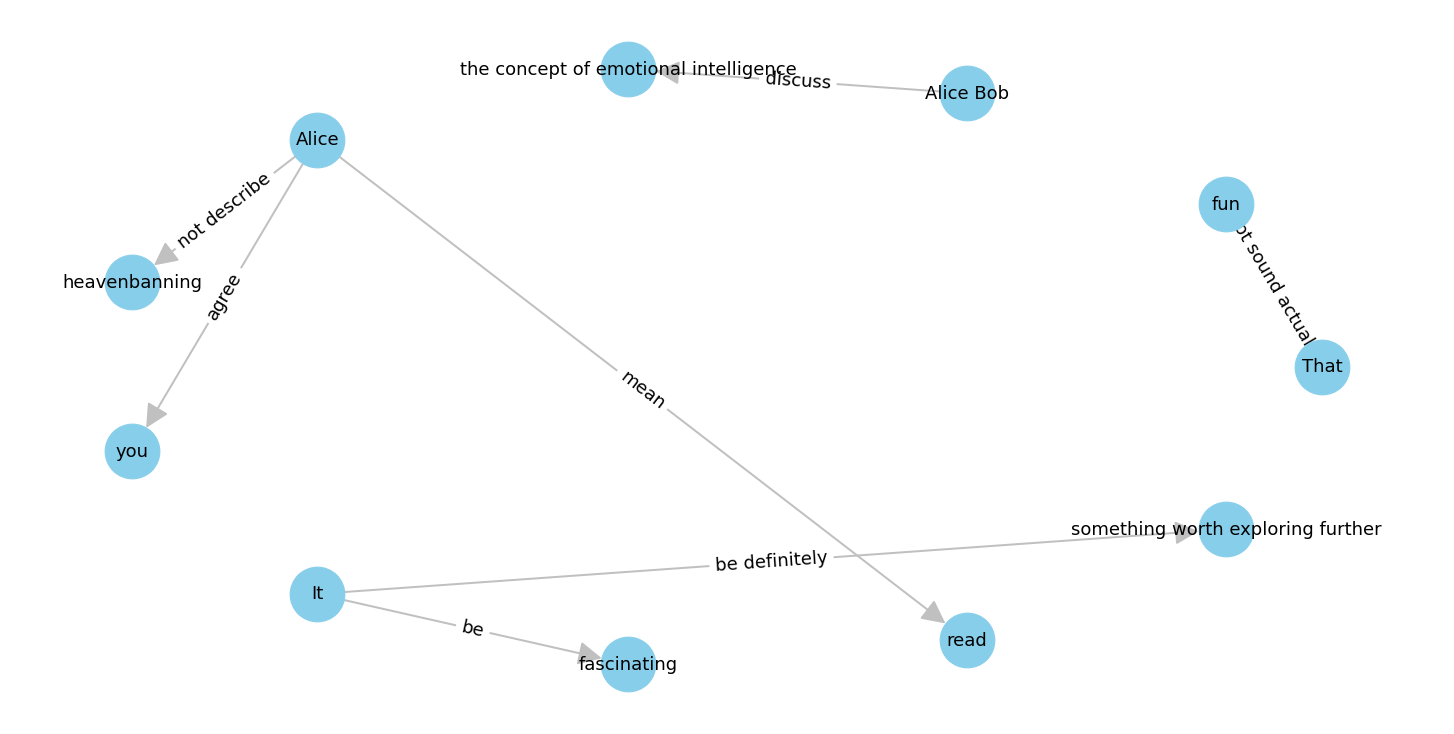

In [271]:
# extract subject
source = [' '.join(i['left']) for i in relations]

# extract object
target = [' '.join(i['right']) for i in relations]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':[i['relation'] for i in relations]})

# create a directed-graph from a dataframe
Gpd=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          
Gpd_edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in Gpd.edges(data=True)])

show_fig(Gpd, Gpd_edge_labels)

In [272]:
kg_df

,source,target,edge
0,That,fun,not sound actually
1,Alice Bob,the concept of emotional intelligence,discuss
2,Alice,heavenbanning,not describe
3,Alice,you,agree
4,It,fascinating,be
5,Alice,read,mean
6,It,something worth exploring further,be definitely


In [273]:
# create a dict and save json
ser = json.dumps(nx.node_link_data(Gpd))
# print(ser)

In [274]:
# load JSON
G=nx.node_link_graph(json.loads(ser))
edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in G.edges(data=True)])

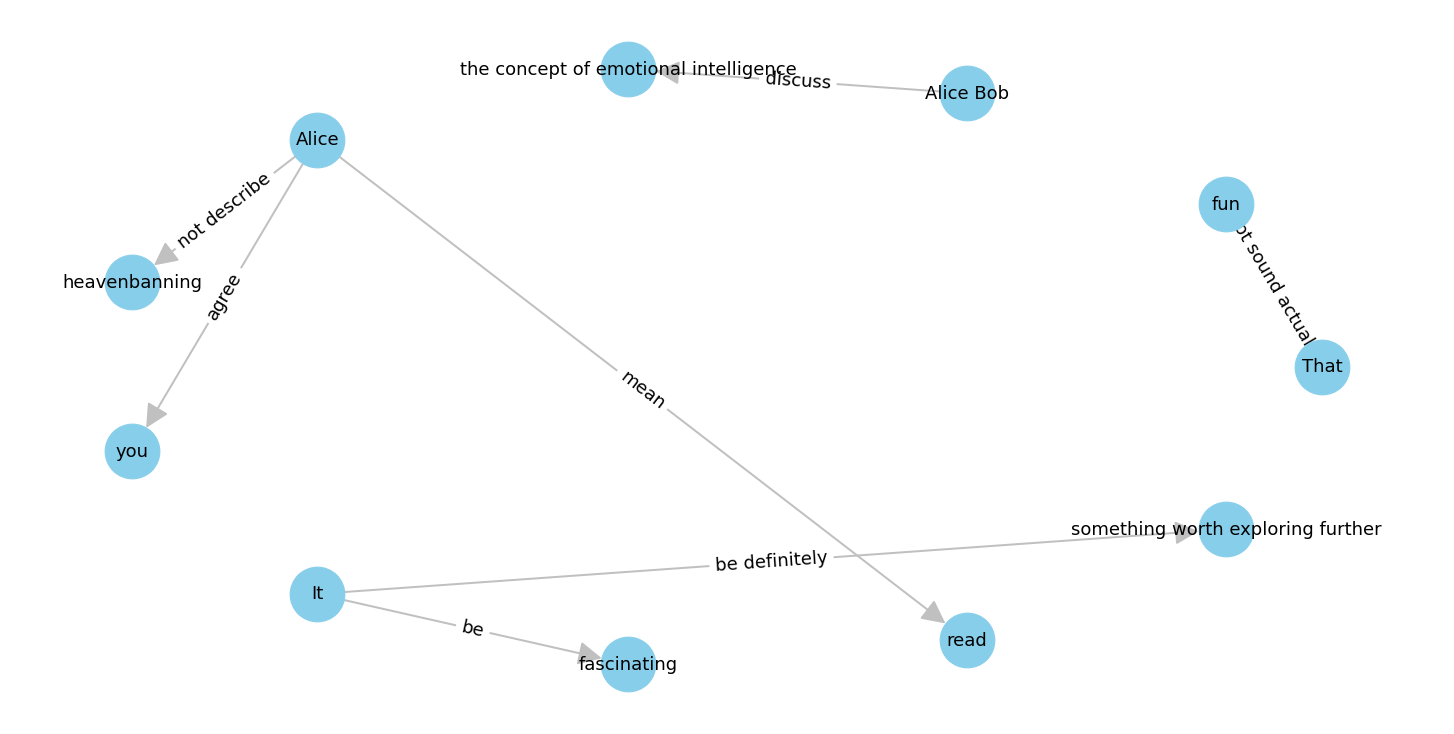

In [275]:
show_fig(G, edge_labels)

In [276]:
assert nx.node_link_data(G) == nx.node_link_data(Gpd)

In [277]:
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)),3)

In [278]:
assert jaccard_similarity(G.nodes(), Gpd.nodes()), jaccard_similarity(G.edges(), Gpd.edges()) == (1.0, 1.0)

In [279]:
# load JSON
G=nx.node_link_graph(json.loads(ser))
G.remove_node('the concept of emotional intelligence')
G.add_node('something else')
G.remove_edge('It', 'fascinating')
G.add_edge('Alice Bob', 'something else', edge='agree')

edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in G.edges(data=True)])

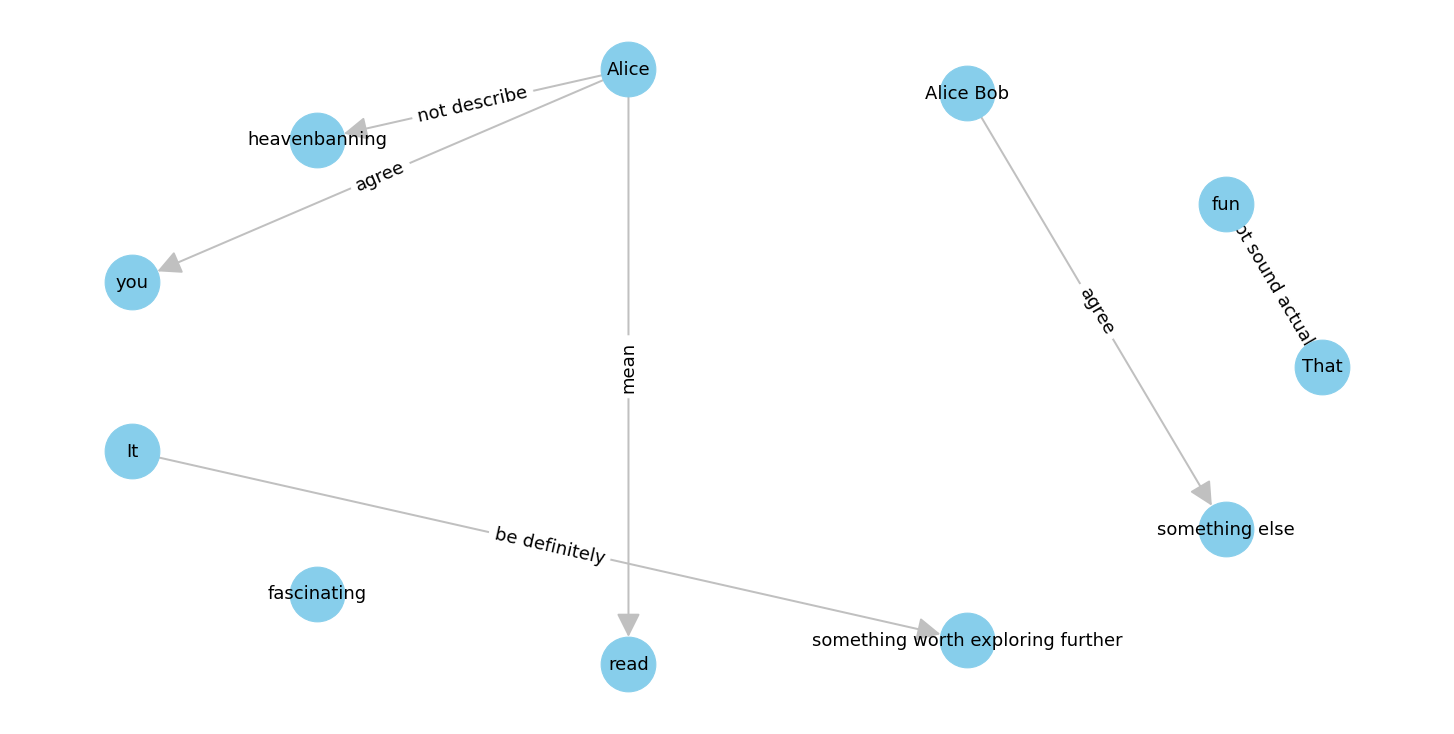

In [280]:
show_fig(G, edge_labels, seed=23)

In [281]:
jaccard_similarity(G.nodes(), Gpd.nodes()), jaccard_similarity(G.edges(), Gpd.edges())

(0.833, 0.625)

In [282]:
a_not_b = set(Gpd.nodes()).difference(set(G.nodes()))
b_not_a = set(G.nodes()).difference(set(Gpd.nodes()))
a_not_b, b_not_a

({'the concept of emotional intelligence'}, {'something else'})

In [283]:
a_not_b = set(Gpd.edges()).difference(set(G.edges()))
for edge in a_not_b:
    print(edge[0], Gpd_edge_labels[edge], edge[1], sep=' | ')

Alice Bob | discuss | the concept of emotional intelligence
It | be | fascinating


In [284]:
b_not_a = set(G.edges()).difference(set(Gpd.edges()))
for edge in b_not_a:
    print(edge[0], edge_labels[edge], edge[1], sep=' | ')

Alice Bob | agree | something else


# Tests follow

In [38]:
rel = gent2("Anna and Hackerfriendly discussed the concept of emotional intelligence and then Anna proposed exploring Erving Goffman's work and its potential implications.")
print(rel)
assert rel == {'left': ['Anna'], 'relation': 'discuss', 'right': ['the concept of emotional intelligence']}

{'left': ['Anna'], 'relation': 'discuss', 'right': ['the concept of emotional intelligence']}


In [39]:
rel = gent2(to_arch("Anna and Hackerfriendly discussed the concept of emotional intelligence and then Anna proposed exploring Erving Goffman's work and its potential implications."))
print(rel)
assert rel == {'left': ['Alice', 'Bob'], 'relation': 'discuss', 'right': ['the concept of emotional intelligence']}

{'left': ['Alice', 'Bob'], 'relation': 'discuss', 'right': ['the concept of emotional intelligence']}


In [40]:
rel = gent2("It's fascinating to think about the possibilities!")
print(rel)
assert rel == {'left': ['It'], 'relation': 'be', 'right': ['fascinating']}

{'left': ['It'], 'relation': 'be', 'right': ['fascinating']}


In [41]:
rel = gent2("Anna agree with you that it doesn't sound particularly fun.", False)
print(rel)
assert rel == {'left': ['Anna'], 'relation': 'agree', 'right': ['you']}

{'left': ['Anna'], 'relation': 'agree', 'right': ['you']}


In [42]:
rel = gent2("Anna recalls was thinking about Bill, the tennis guy.", False)
print(rel)
assert rel == {'left': ['Anna'], 'relation': 'recall', 'right': ['thinking']}

{'left': ['Anna'], 'relation': 'recall', 'right': ['thinking']}


In [43]:
rel = gent2("He was a programmer trying to solve an issue with his computer, but he wasn't sure how.", False)
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['He'], 'be', ['trying'])

{'left': ['He'], 'relation': 'be', 'right': ['trying']}


In [44]:
rel = gent2("Even when other kids his age had left to play professional football or basketball, Bill stayed dedicated to his passion for tennis and continued to practice hard every day.")
print(rel)
assert rel == {'left': ['Bill'], 'relation': 'stay', 'right': ['dedicated']}

{'left': ['Bill'], 'relation': 'stay', 'right': ['dedicated']}


In [45]:
rel = gent2("He started playing at the age of 8.", False)
print(rel)
assert rel == {'left': ['He'], 'relation': 'start', 'right': ['playing at the age of 8']}

{'left': ['He'], 'relation': 'start', 'right': ['playing at the age of 8']}


In [46]:
rel = gent2("He didn't start playing at the age of 8 but quickly became known as one of the best players in town.", False)
print(rel)
assert rel == {'left': ['He'], 'relation': 'not start', 'right': ['playing']}

{'left': ['He'], 'relation': 'not start', 'right': ['playing']}


In [47]:
rel = gent2("Anna and Ricky and their friend's cousin's dog Phil discussed the work of Erving Goffman and the commonalities between various activities.")
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['Anna', 'Phil', 'Ricky'], 'discuss', ['the work'])

{'left': ['Anna', 'Phil', 'Ricky'], 'relation': 'discuss', 'right': ['the work']}


In [48]:
rel = gent2("Anna and Ricky and their friend Jim's cousin's butler, Phil, discussed the work of Erving Goffman and the commonalities between various activities.")
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['Anna', 'Phil', 'Ricky'], 'discuss', ['the work'])

{'left': ['Anna', 'Phil', 'Ricky'], 'relation': 'discuss', 'right': ['the work']}


In [49]:
print([tok for tok in nlp_merged(to_arch("hackerfriendly was thinking about Bill, the tennis guy."))])
print([tok.pos_ for tok in nlp_merged(to_arch("hackerfriendly was thinking about Bill, the tennis guy."))])

[Alice, was, thinking, about, Bob, ,, the tennis guy, .]
['PROPN', 'AUX', 'VERB', 'ADP', 'PROPN', 'PUNCT', 'NOUN', 'PUNCT']


In [50]:
rel = gent2("Hackerfriendly was thinking about Bill, the tennis guy.", False)
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['Hackerfriendly'], 'think', ['the tennis guy'])

{'left': ['Hackerfriendly'], 'relation': 'think', 'right': ['the tennis guy']}


In [51]:
rel = gent2("hackerfriendly was thinking about Bill, the tennis guy, and his buddy Charlie.", render=False)
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['hackerfriendly'], 'think', ['Bill', 'Charlie', 'the tennis guy'])

{'left': ['hackerfriendly'], 'relation': 'think', 'right': ['Bill', 'Charlie', 'the tennis guy']}


In [52]:
doc = nlp_coref("hackerfriendly was thinking about Bill, the tennis guy, and his buddy Charlie.")
displacy.render(doc, "ent")

In [53]:
speaker = Span(doc, 0, 1, label="PERSON")
doc.set_ents([speaker], default="unmodified")
print([(e.text, e.start, e.end, e.label_) for e in doc.ents])

[('hackerfriendly', 0, 1, 'PERSON'), ('Bill', 4, 5, 'PERSON'), ('Charlie', 13, 14, 'PERSON')]


In [54]:
displacy.render(doc, "ent")

In [55]:
displacy.render(doc)

In [56]:
tok = doc[0]
tok

hackerfriendly

In [57]:
tok.tag_, tok.dep_

('NNP', 'nsubj')

In [61]:
assert gent2("mfkje lfkj kajhkljhdkjh") == {'left': [], 'relation': [], 'right': []}

Root is not a verb, can't continue.


In [62]:
rel = gent2("In desperation, he took it apart and managed to fix it himself.", False)
print(rel)
assert (rel['left'], rel['relation'], rel['right']) == (['he'], 'take apart', ['it'])

{'left': ['he'], 'relation': 'take apart', 'right': ['it']}


In [63]:
rel = gent2("That doesn't actually sound like fun, for the person stuck in VR with you.", False)
print(rel)
assert rel == {'left': ['That'], 'relation': 'not sound actually', 'right': ['fun']}

{'left': ['That'], 'relation': 'not sound actually', 'right': ['fun']}


In [64]:
rel = gent2("No, Anna be not describing heavenbanning. ", False)
print(rel)
assert rel == {'left': ['Anna'], 'relation': 'not describe', 'right': ['heavenbanning']}

{'left': ['Anna'], 'relation': 'not describe', 'right': ['heavenbanning']}


In [65]:
to_arch("Anna and Hackerfriendly discussed the concept of emotional intelligence and then Anna proposed exploring Erving Goffman's work and its potential implications.")

"Alice and Bob discussed the concept of emotional intelligence and then Alice proposed exploring Carol Dave 's work and its potential implications."

In [66]:
ts = "Anna and Hackerfriendly talked to Phil, and Anna mentioned Erving Goffman's sister Edith. Hackerfriendly thought it was funny, and so did Phil."

displacy.render(nlp(ts))
displacy.render(nlp(to_arch(ts)))

In [67]:
for a in archetypes + ['hackerfriendly']:
    print(a, nlp_coref(a)[0].pos_)

Alice PROPN
Bob PROPN
Carol PROPN
Dave PROPN
Eve PROPN
Frank PROPN
Gavin PROPN
Heidi PROPN
Ivan PROPN
Judy PROPN
Kaitlin PROPN
Larry PROPN
Mia PROPN
Natalie PROPN
Oliver PROPN
Peggy PROPN
Quentin PROPN
Rupert PROPN
Sophia PROPN
Trent PROPN
Ursula PROPN
Victor PROPN
Wanda PROPN
Xavier PROPN
Yolanda PROPN
Zahara PROPN
hackerfriendly PROPN
